In [3]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [4]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

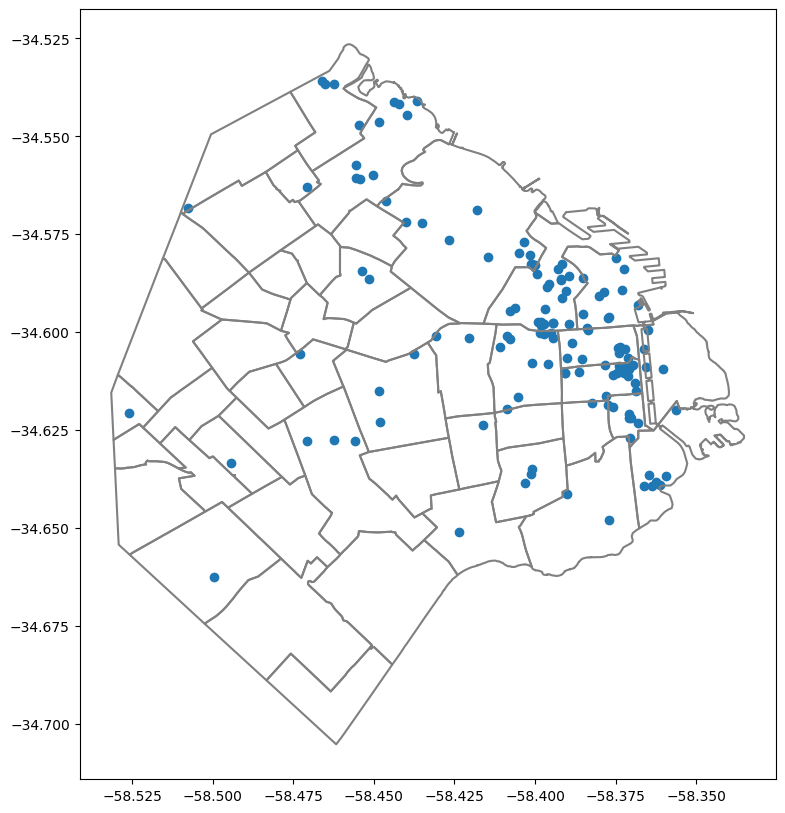

In [5]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [6]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [7]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [8]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

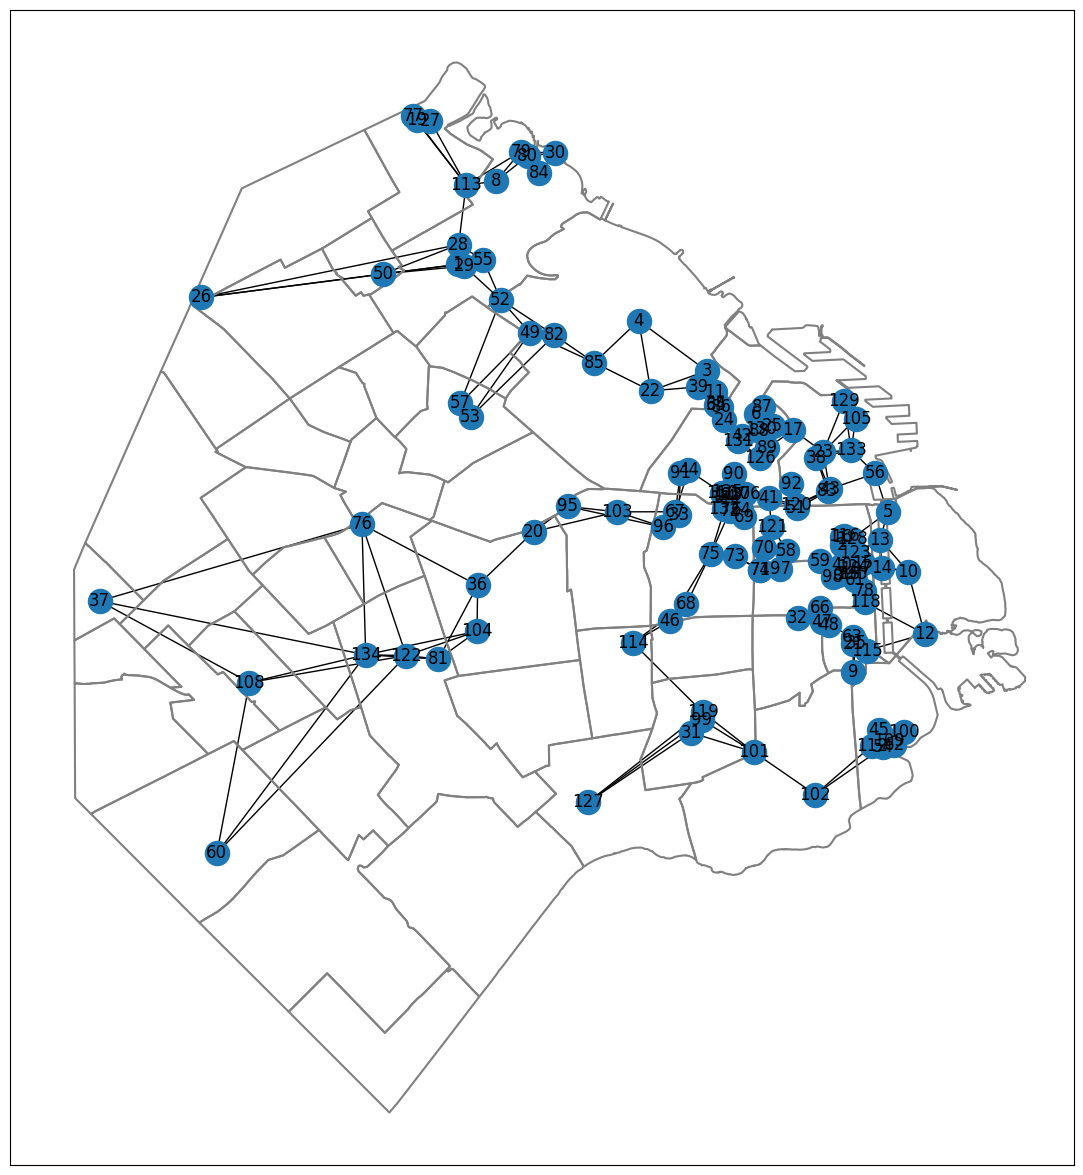

In [9]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

$\vec{p} = (1 - \alpha)C\vec{p} + \frac{\alpha}{N}\vec{1}$

$\vec{p} - (1 - \alpha)C\vec{p} = \frac{\alpha}{N}\vec{1}$

$(I - (1 - \alpha)C)\vec{p} = \frac{\alpha}{N}\vec{1}$

$\frac{N}{\alpha}(I - (1 - \alpha)C)\vec{p} = \vec{1}$

Luego, nos queda la siguiente ecuación matricial.

$M = \frac{N}{\alpha}(I - (1 - \alpha)C)$

$b = \vec{1}$

$M\vec{p} = \vec{1}$

## Punto 2:


a) ¿Qué condiciones se deben cumplir para que exista una solución única a la ecuación del punto anterior?

La matriz debe ser invertible. Por lo tanto queremos ver que $\det(M) \neq 0$, es decir

$\det\left(\frac{N}{\alpha}(I - (1 - \alpha)C)\right) \neq 0$

$\left(\frac{N}{\alpha}\right)^N \det((I - (1 - \alpha)C)) \neq 0$

Si $\alpha = 1$ tenemos que $1 - \alpha = 0$ y nuestra expresión se reduce a

$(N)^N \det(I - (0)C) = (N)^N \det(I) = (N)^N$

Cómo $N \in \mathbb{N}_{\geq 1}$, para cualquier cantidad de museos tenemos que $N^N \neq 0$, y por lo tanto $\det(M) \neq 0$.

Si $\alpha = 0$ no se cumple la ecuación anterior pues $N/0$ es indefinido.

Caso $0 < \alpha < 1$,

Supongamos que $I - (1 - \alpha)C$ no es invertible, entonces existe $\vec{x} \in \mathbb{R}^n: \vec{x} \neq \vec{0}$ tal que

$(I - (1 - \alpha)C)\vec{x} = 0$

$\vec{x} - (1 - \alpha)C\vec{x} = 0$

$\vec{x} = (1 - \alpha)C\vec{x}$

Aplico norma 1 a ambos lados

$\|\vec{x}\|_1 = \|(1 - \alpha)C\vec{x}\|_1$

$\|\vec{x}\|_1 = |1 - \alpha|\|C\vec{x}\|_1$

$\|\vec{x}\|_1 \leq |1 - \alpha|\|C\|_1\|\vec{x}\|_1$

Cómo $\|C\|_1 = 1$, pues C es estocástica, y además $(0 < \alpha < 1)$

$\|\vec{x}\|_1 \leq (1 - \alpha)\|\vec{x}\|_1$

$\|\vec{x}\|_1 - (1 - \alpha)\|\vec{x}\|_1 \leq 0$

$\alpha\|\vec{x}\|_1 \leq 0$

Cómo $\alpha \neq 0$

$\|\vec{x}\|_1 \leq 0$

Esto ocurre, sí y sólo sí, $\vec{x} = \vec{0}$, llegando a un absurdo.

Por lo tanto $(I - (1 - \alpha)C)$ es invertible, entonces

$\det(M) = \det\left(\frac{N}{\alpha}(I - (1 - \alpha)C)\right) = \left(\frac{N}{\alpha}\right)^N \det(I - (1 - \alpha)C)$

con $\left(\frac{N}{\alpha}\right)^N \neq 0$ y $\det(I - (1 - \alpha)C) \neq 0$. Es decir

$\det(M) \neq 0$

Con lo cual la matriz $M$ es invertible y existe solución única para

$M\vec{p} = \vec{1}$

## Punto 3:

In [10]:
import template_funciones as func

In [11]:
def graficar(p, ax, titulo, k=50_000):
  # recibe:
  #  - p (numpy.ndarray): Matriz (N, 1) con los puntajes.
  #  - ax (matplotlib.axes.Axes): Eje matplotlib donde dibujar el gráfico.
  #  - titulo: título del gráfico
  #  - k: escalar para redimencionar los nodos, a partir del puntaje
  
  
  # Trasponemos P para que sea un vector de N elementos
  # La multiplicamos por 50_000 para que represente el tamaño de cada nodo, y sean más vicibles
  node_size = p.T[0] * k

  # fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios

  nx.draw_networkx(G,G_layout,node_size = node_size, ax=ax,with_labels=False) # Graficamos red

  ax.set_title(titulo)
  # plt.show()

def graficar_bar_plot(df, ax, alpha, m):
  # recibe:
  #  - "df": un dataframe con las columnas "nodos", "puntaje", "alpha" y "m", ordenados descendientemente por "puntaje"
  #  - ax (matplotlib.axes.Axes): Eje matplotlib donde dibujar el gráfico.
  #  - "alpha": el alpha en eq. 3
  #  - "m": cantidad de conecciones
  
  df.head(3).plot(kind='bar', x='nodos', y='puntaje', legend=False, title=f'Top 3 puntajes con alpha={alpha} y {m} vecinos', ax=ax)
  
  # Add values on top of each bar
  for p in ax.patches:
      ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=10)
  
  # Set the y-axis label
  ax.set_ylabel("Puntaje")

  # Set the x-axis label
  ax.set_xlabel("Nodo")
  

def create_df(nodes, puntaje, alpha, m):
  # recibe:
  #  - "nodes": una lista con los id's de cada nodo
  #  - "puntaje": una matriz (N,1) con los puntajes de cada nodo.
  #  - "alpha": el alpha en la eq. 3
  #  - "m": la cantidad de conecciones que tiene cada museo
  # retorna:
  #  - un dataframe con 4 columnas: "nodes","score","alpha","m" ordenado descendientemente por "puntaje"

  size = len(nodes)
  a_arr = [alpha]*size
  m_arr = [m]*size

  df = pd.DataFrame({"nodos":nodes,"puntaje":puntaje, "alpha":a_arr, "m":m_arr})
  df = df.sort_values(by="puntaje", ascending=False)
  return df


### a)

Graficamos la red utilizando el puntaje para 3 conecciones y un $\alpha=0.5$

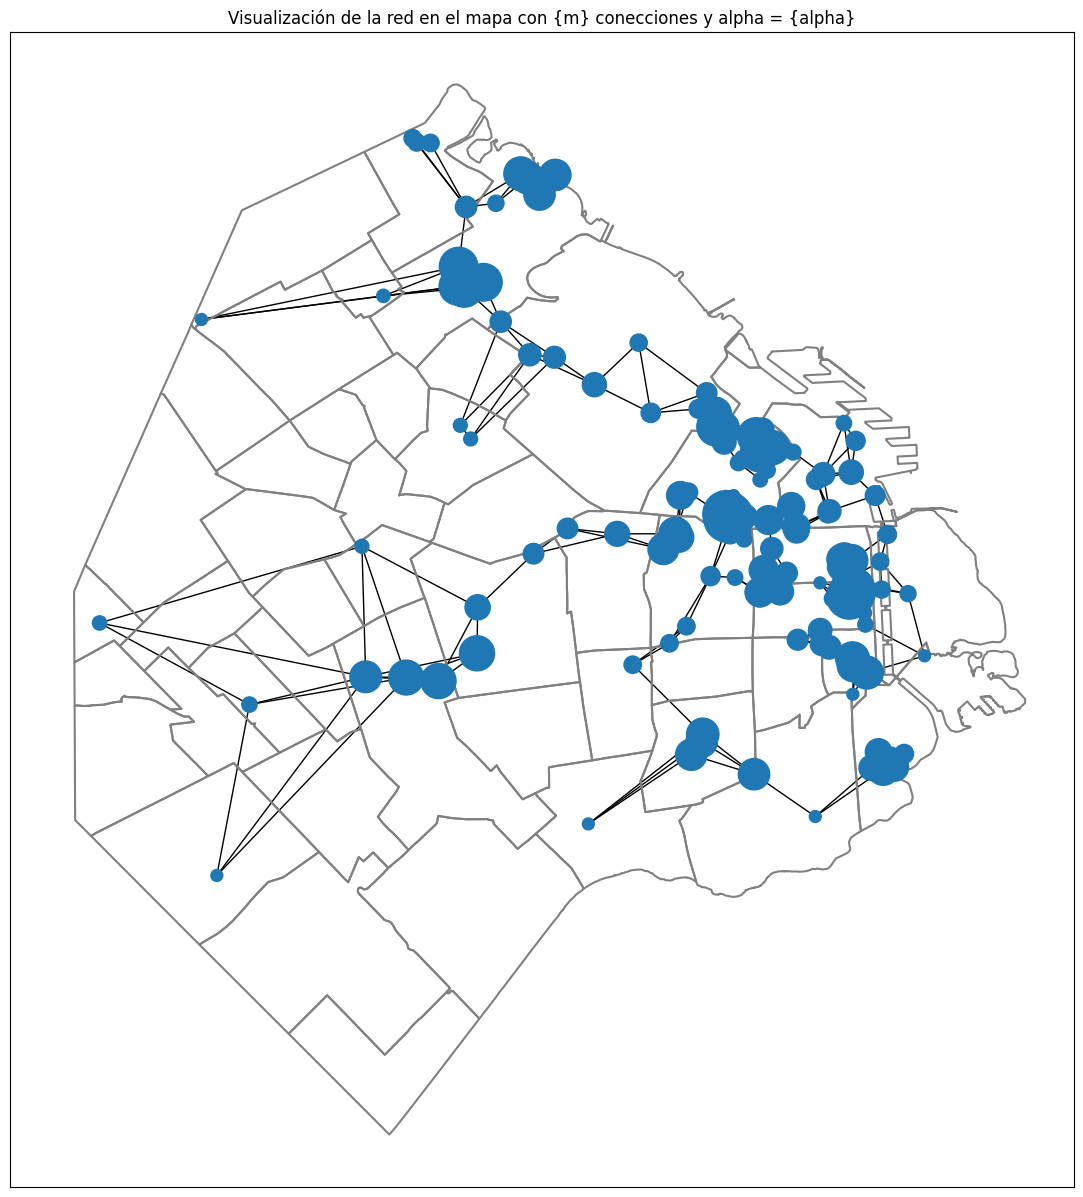

In [12]:
m = 3
alpha = 1/5
A = func.construye_adyacencia(D, m)

p = func.calcula_pagerank(A,alpha)

fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
titulo = "Visualización de la red en el mapa con {m} conecciones y alpha = {alpha}"
graficar(p,ax,titulo)
plt.show()

### b)

Graficamos las conecciones y los nodos utilizando el puntaje para $m \in \{1,3,5,10\}$ y $\alpha = 0.5$

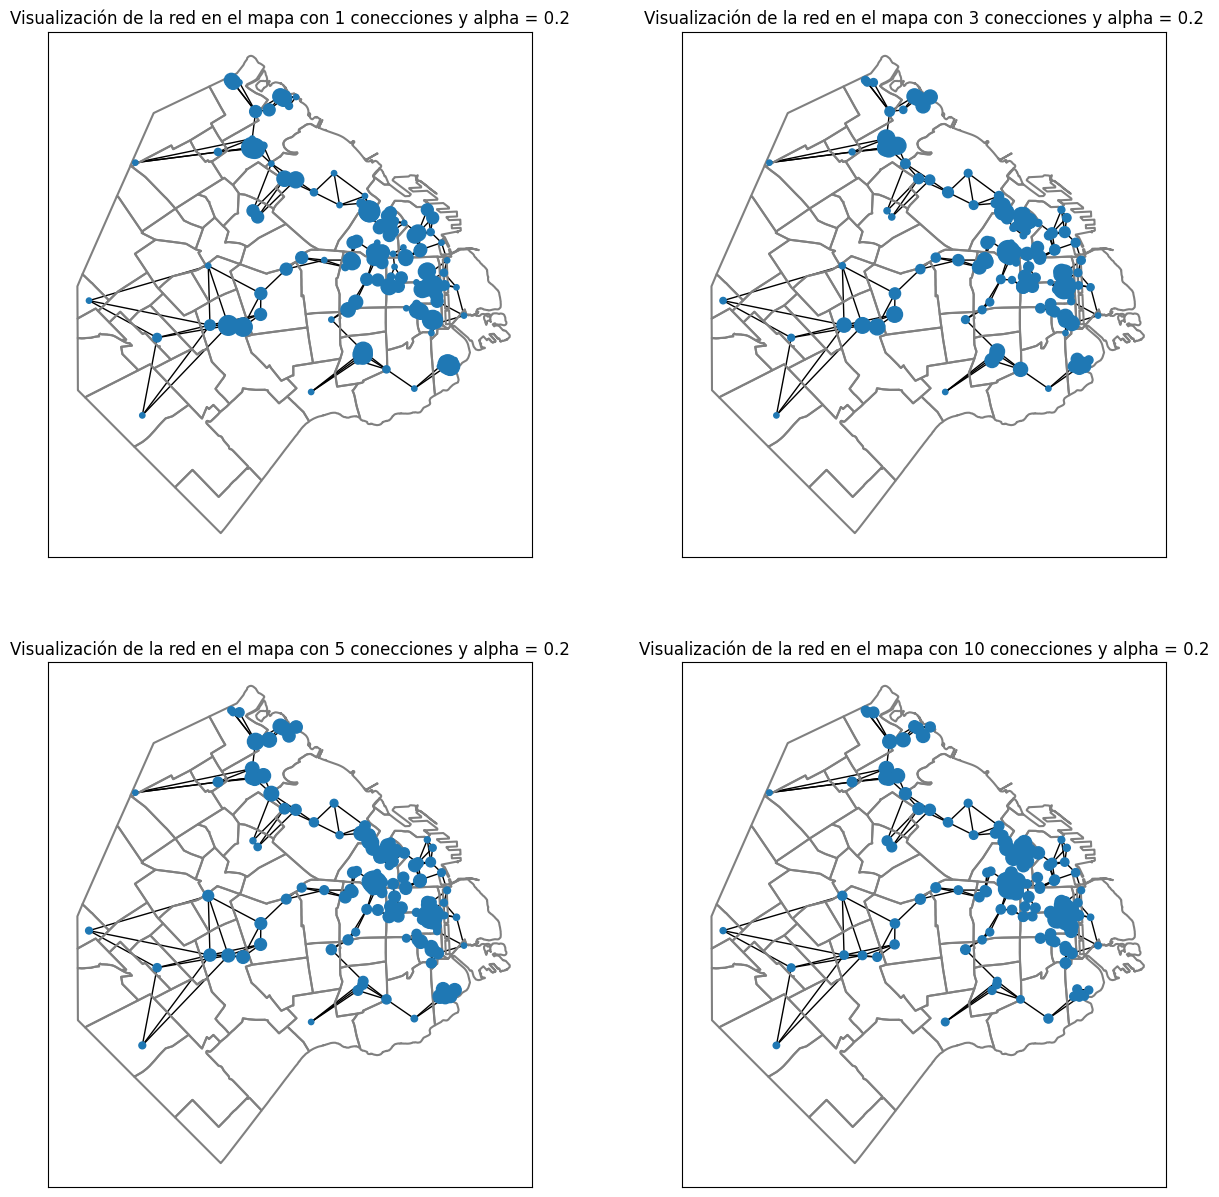

In [13]:
conecciones = [1,3,5,10]
alpha = 1/5
fig, axs = plt.subplots(2,2, figsize=(15, 15))
axs = axs.flatten()
for i in range(len(conecciones)):
  m = conecciones[i]
  ax = axs[i]
  A = func.construye_adyacencia(D, m)
  p = func.calcula_pagerank(A,alpha)
  titulo = f"Visualización de la red en el mapa con {m} conecciones y alpha = {alpha}"
  graficar(p,ax,titulo,k=10000)

plt.show()

### c)

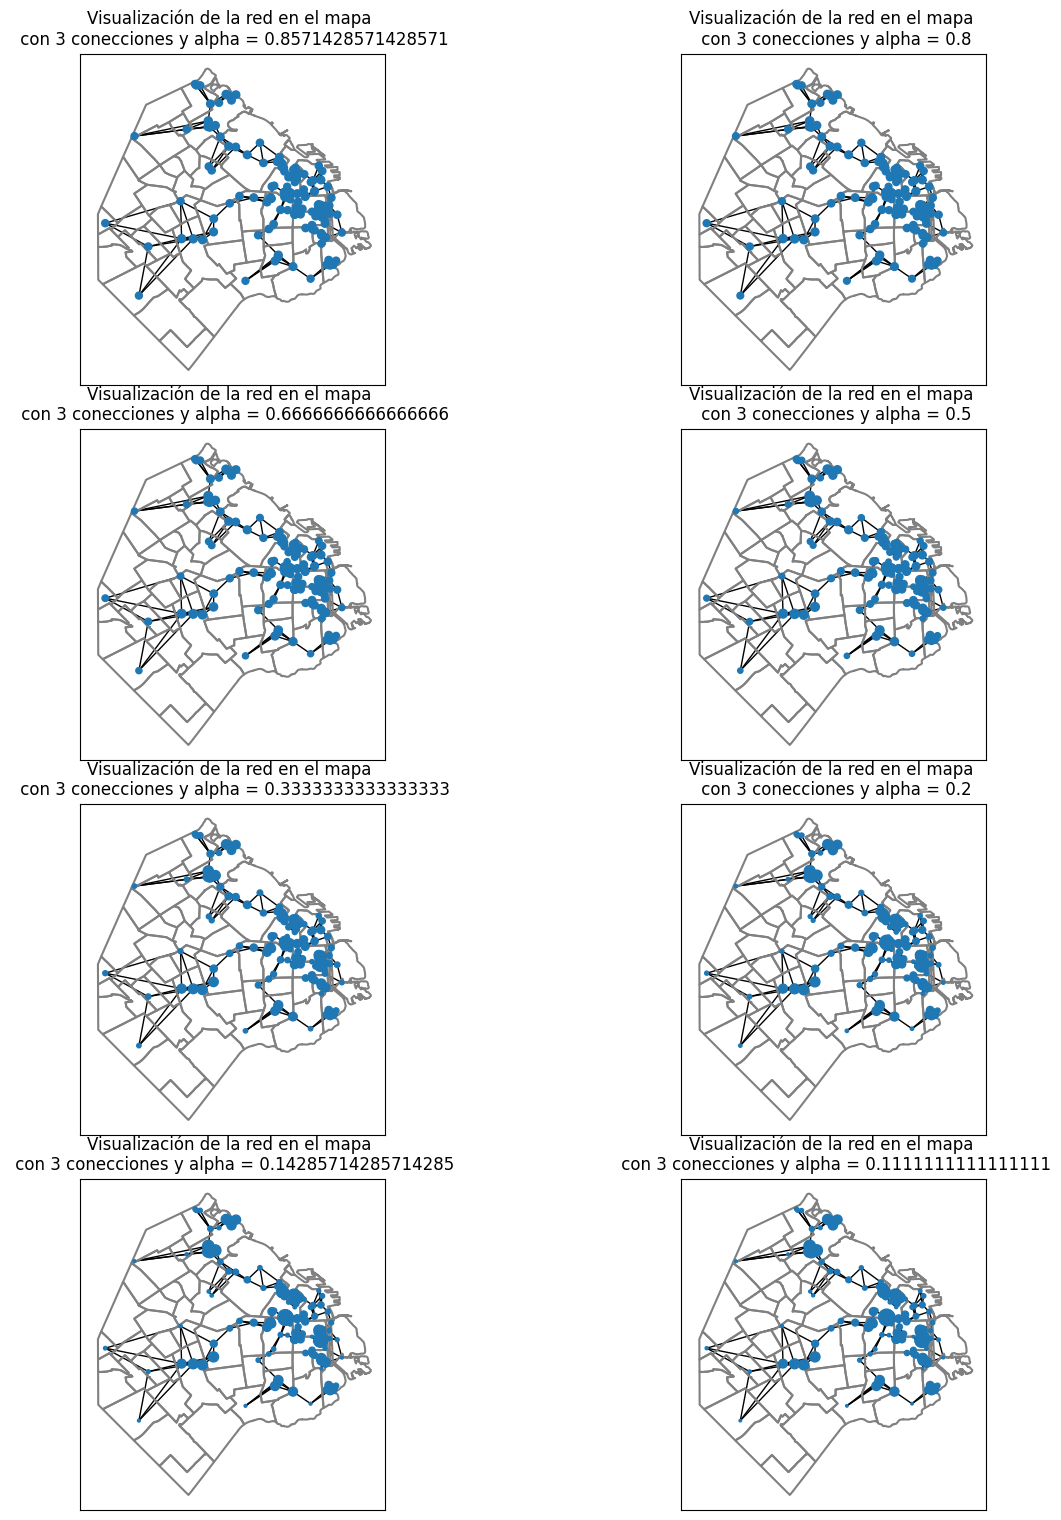

In [14]:
m = 3
alpha = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7, 1/9]
fig, axs = plt.subplots(4,2, figsize=(15, 15))
axs = axs.flatten()
for i in range(len(alpha)):
  a = alpha[i]
  ax = axs[i]
  A = func.construye_adyacencia(D, m)
  p = func.calcula_pagerank(A,a)
  titulo = f"Visualización de la red en el mapa \n con {m} conecciones y alpha = {a}"
  graficar(p,ax,titulo, k=4000)

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

Usando los **p** obtenidos antes, estudiamos que pasa con los puntajes

Variando las conecciones $m$ y dejando $\alpha$ costante, obtenemos 4 rankings (para $m=1,3,5,10$). De cada uno tomamos los 3 museos con mejor puntaje y los graficamos cómo varían en función de la cantidad de conecciones.

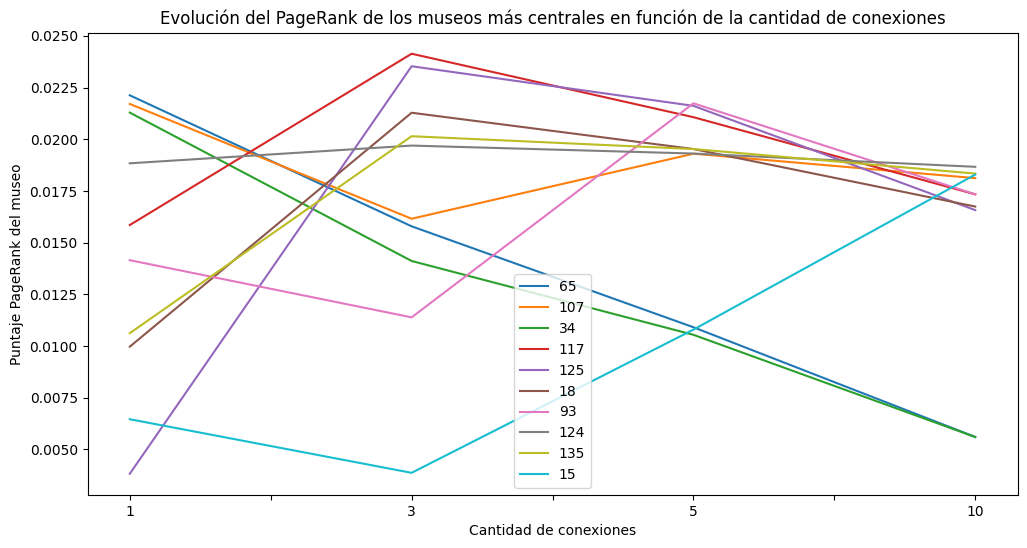

In [29]:
conexiones = [1,3,5,10]
alpha = 1/5

# Construímos una lista de rankings
Ps_segun_conexiones = []
for m in conexiones:
    A = func.construye_adyacencia(D,m)
    p = func.calcula_pagerank(A, 1/5)
    Ps_segun_conexiones.append(p)
df_m_movil = pd.DataFrame(np.array(Ps_segun_conexiones).T[0], columns=["1", "3", "5", "10"])

# Tomamos los tres mejores puntajes según su cantidad de conecciones
top3_1 = df_m_movil.sort_values(by="1", ascending=False).head(3)
top3_3 = df_m_movil.sort_values(by="3", ascending=False).head(3)
top3_5 = df_m_movil.sort_values(by="5", ascending=False).head(3)
top3_10 = df_m_movil.sort_values(by="10", ascending=False).head(3)

# Construimos el dataframe de los mejores museos
df_graf_m_movil = pd.concat([top3_1, top3_3, top3_5, top3_10]).drop_duplicates()

# Graficamos
df_graf_m_movil.T.plot(figsize=(12,6))
plt.xlabel("Cantidad de conexiones")
plt.ylabel("Puntaje PageRank del museo")
plt.title("Evolución del PageRank de los museos más centrales en función de la cantidad de conexiones")
plt.show()

**Observaciones**:
Para un factor de amortiguamiento fijo y una cantidad de conexiones móvil, no se observa una convergencia clara de los puntuajes del PageRank en función del m, ya que si bien particularmente para los museos 65 y 34 sus puntajes decrecen a medida que aumenta la cantidad de conexiones, para el resto de museos centrales se observa un comportamiento mas errático del puntaje, teniendo tanto picos como caídas de puntaje

Dejando la cantidad de conneciones $m$ constante, y variando el alpha, obtenemos el siguiente gráfico con la misma estrategia que el anterior.

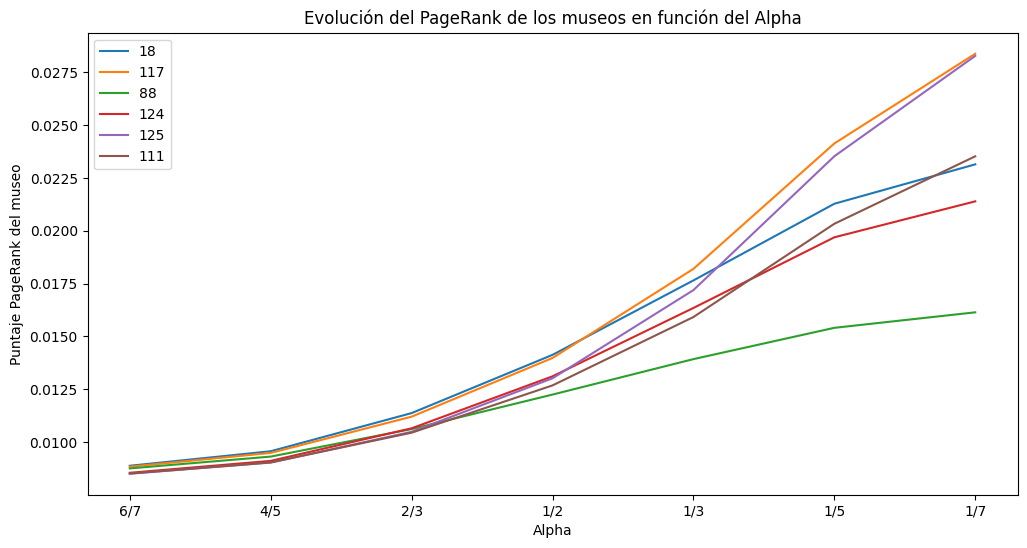

In [28]:
m = 3
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
A = func.construye_adyacencia(D,m)

# Construimos una lista de rankings
lista_Ps = []
for a in alphas:
    p = func.calcula_pagerank(A,a)
    lista_Ps.append(p)
df_alpha_movil = pd.DataFrame(np.array(lista_Ps).T[0], columns = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"])

# Tomamos los mejores museos
top3_67 = df_alpha_movil.sort_values(by="6/7", ascending=False).head(3)
top3_45 = df_alpha_movil.sort_values(by="4/5", ascending=False).head(3)
top3_23 = df_alpha_movil.sort_values(by="2/3", ascending=False).head(3)
top3_12 = df_alpha_movil.sort_values(by="1/2", ascending=False).head(3)
top3_13 = df_alpha_movil.sort_values(by="1/3", ascending=False).head(3)
top3_15 = df_alpha_movil.sort_values(by="1/5", ascending=False).head(3)
top3_17 = df_alpha_movil.sort_values(by="1/7", ascending=False).head(3)

# Construimos el dataframe con los mejores museos
df_graf = pd.concat([top3_67, top3_45, top3_23, top3_12, top3_13, top3_15, top3_17]).drop_duplicates()

# Graficamos
df_graf.T.plot(figsize=(12, 6))
plt.xlabel("Alpha")
plt.ylabel("Puntaje PageRank del museo")
plt.title("Evolución del PageRank de los museos en función del Alpha")
plt.show()

**Observaciones**:En el gráfico se aprecia como los puntajes de los museos más centrales disminuyen a medida que el alpha crece, convergiendo en un número menor a 0.01

Par una cantidad de conexiones fija, a medida que el factor de amortiguamiento disminuye, el ranking favorece a los museos ubicados en la zonas donde hay una mayor concentración de museos pertenecientes a la red. Por el contrario, a medida que el factor de amortiguación aumenta, el ranking deja de estar tan acentuado para pasar a ser más equitativo.

Esto es consecuente con la ecuación utilizada para calcular el ranking, ya que a medida que el factor de amortiguamiento tiende a 1, la matriz de transiciones que refleja la distribución de los museos y la cantidad de conexiones pasa a tener menos peso en el ranking, y cuando tiende a 0, el ranking está cada vez marcado por la disposición de los museos en el mapa

## Punto 4:

Si la matriz $C^k$ representa la probabilidad de que un visitante vaya a un determinado museo, entonces dados dos vectores $v, w$ tales que

$w = Cv + v$

Decimos que $v_i$ tiene la información de cuantos visitantes hay en el museo $i$, y $w_i$ tendrá la información de cuantos visitantes habrá en el siguiente. Luego,

$w = C^2v + Cv + C^0v$

Ahora $w_i$ almacena la información de la cantidad de visitantes que tendrá cada museo en el tercer paso. (tomamos $C^0$ cómo el primero).

$w = C^{r-1}v + \dots + v + Cv + C^0v$

Ahora $w_i$ almacena la información de la cantidad de visitantes que tendrá cada museo en el $r$-paso. Lo anterior es lo mismo que decir

$w = \sum_{k=0}^{r-1} C^k v$

$w = \left(\sum_{k=0}^{r-1} C^k\right) v$

Luego, si decimos que $B = \sum_{k=0}^{r-1} C^k$ nos podemos quedar con la siguiente ecuación.

$w = Bv$

Finalmente la siguiente es una buena aproximación a la cantidad de visitantes que tuvo inicialmente cada museo.

$v = B^{-1}w$

## Punto 5:

Utilizamos la función "calcula_matriz_C_contínua" para resolver la ecuación 

$v = B^{-1}w$

In [18]:
C = func.calcula_matriz_C_continua(D)

# Leer vector w desde el archivo "visitas.txt"
w = [] # vector w
with open("./visitas.txt", "r") as file:
  w = [float(line.strip()) for line in file]

Id = np.eye(len(w))
r = 3 # cantidad de pasos
B = func.calcula_B(C,r)

# Calculamos LU de B y encontramos la estimación de visitas inciales (v)
[L,U] = func.calculaLU(B)
J = scipy.linalg.solve_triangular(L, w, lower=True)
v = scipy.linalg.solve_triangular(U, J)

# Calculamos norma 1 de v
v_norma_1 = 0
for elem in v:
  v_norma_1 += np.abs(elem)
v_norma_1
print(v_norma_1)


c:\Users\nahue\Desktop\ALC-Apuntes\TP\template_funciones.py:90: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


136604.99999999994


## Punto 6:

In [19]:
def norma1(M):
    # Toma una matriz M
    # Devuelve su norma 1
    norma_provisional = 0
    for i in range(M.shape[1]):
        sum_abs_columna = 0
        for j in range(M.shape[0]):
            sum_abs_columna += abs(M[j][i])
        if sum_abs_columna > norma_provisional:
            norma_provisional = sum_abs_columna
    return norma_provisional

In [20]:
[L,U] = func.calculaLU(B)
L_inv = scipy.linalg.solve_triangular(L, np.eye(L.shape[0]), lower=True)
U_inv = scipy.linalg.solve_triangular(U, np.eye(U.shape[0]))
B_inv = U_inv @L_inv
nroCond_B = norma1(B)*norma1(B_inv)
print(nroCond_B)

5.051771176665008


In [21]:
cota_error_estimacion_v = nroCond_B*0.05
print(cota_error_estimacion_v)

0.25258855883325043


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

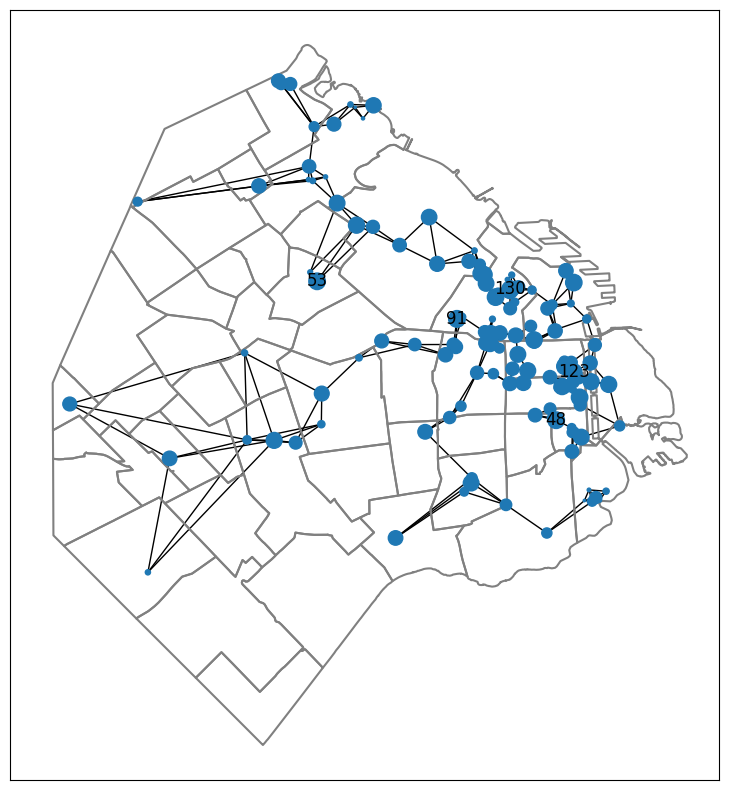

In [22]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=12, font_color="k") # Agregamos los nombres